In [1]:
!python --version
!nvcc --version
!pip list

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Package                          Version
-------------------------------- ------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
auto

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

C:\Users\EaglesonLabs\Anaconda2\envs\vit-object-detection\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import pathlib, os, random
data_dir = pathlib.Path("obj/").with_suffix('')
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

def list_files(full_data_path = "obj/", image_ext = '.jpg'):

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")
    random.shuffle(files)
    return files

files = list_files()


1510
218 file(s) discarded
1292 valid case(s)
832 are masked cases


In [5]:
def read_yolo_annotation_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:
        parts = line.strip().split(' ')
        object_class = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        annotations.append((object_class, x_center, y_center, width, height))

    return annotations

In [6]:
image_size = 224  # resize input images to this size
num_classes = 2 # the number of classes in the dataset
images, targets, classes = [], [], []

# loop over the annotations and images, preprocess them and store in lists
for file in files:
    # load the x,y,w,h of the bounding box here as top_left_x/y & bottom_right_x/y
    annotations = read_yolo_annotation_file('obj/' + file + '.txt')
    class_prediction = annotations[0][0]
    top_left_x = annotations[0][1]
    top_left_y = annotations[0][2]
    bottom_right_x = annotations[0][3]
    bottom_right_y = annotations[0][4]
    
    # load the actual image here
    image = keras.utils.load_img("obj/" + file + '.jpg',)
    image = image.resize((image_size, image_size))
    
    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))
    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x),
            float(top_left_y),
            float(bottom_right_x),
            float(bottom_right_y),
        )
    )
    classes.append(to_categorical(class_prediction, num_classes))



# Convert the list to numpy array, split to train and test dataset
(x_train), (bounding_boxes_y_train), (class_labels_y_train) = (
    np.asarray(images[:int( 0.8  *len(images))],dtype=object),
    np.asarray(targets[:int(0.8 * len(targets))],dtype=object),
    np.asarray(classes[:int(0.8 * len(classes))],dtype=object),
)

(x_test), (bounding_boxes_y_test), (class_labels_y_test) = (
    np.asarray(images[int(0.8 * len(images)):],dtype=object),
    np.asarray(targets[int(0.8 * len(targets)):],dtype=object),
    np.asarray(classes[int(0.8 * len(classes)):],dtype=object),
)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
bounding_boxes_y_train = tf.convert_to_tensor(bounding_boxes_y_train, dtype=tf.float32)
class_labels_y_train = tf.convert_to_tensor(class_labels_y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
bounding_boxes_y_test = tf.convert_to_tensor(bounding_boxes_y_test, dtype=tf.float32)
class_labels_y_test = tf.convert_to_tensor(class_labels_y_test, dtype=tf.float32)

bounding_box:  [0.48886988 0.46270928 0.18321918 0.325723  ]
label:  0


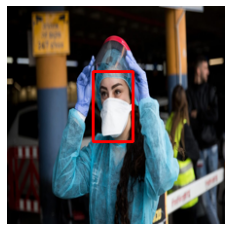

In [7]:
num = 0

image = x_train[num].numpy().astype("uint8")



bounding_box = bounding_boxes_y_train[num].numpy()
label = np.argmax(class_labels_y_train[num].numpy())
print('bounding_box: ', bounding_box)
print('label: ', label)

x_center, y_center = bounding_box[0] * image_size,  bounding_box[1] * image_size
width, height = bounding_box[2] * image_size,  bounding_box[3] * image_size

# Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
x_min = int(x_center - (width / 2))
y_min = int( y_center - (height / 2))
x_max = x_min + int(width)
y_max = y_min + int(height)

top_left = (x_min, y_min)
bottom_right = (x_max, y_max)

# Convert image to RGB if it's grayscale
image = np.squeeze(image)  # Remove the extra batch dimension
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Draw rectangles
cv2.rectangle(image, top_left, bottom_right, (255,0,0), 2)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

In [8]:
architecture_id = 'base architecture + custom dataset'

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

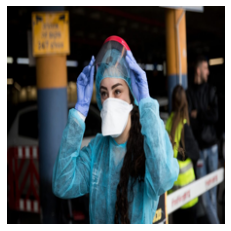

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


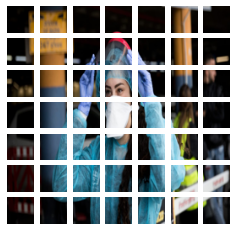

In [11]:
import matplotlib.pyplot as plt

patch_size = 32  # Size of the patches to be extracted from the input images

# Convert the EagerTensor to a NumPy array
x_train_numpy = x_train[0].numpy().astype("uint8")

plt.figure(figsize=(4, 4))
plt.imshow(x_train_numpy)
plt.axis("off")
plt.show()

patches = Patches(patch_size)(tf.convert_to_tensor([x_train_numpy]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Final MLP head for bounding box prediction
    bounding_box = layers.Dense(4, name='bounding_box')(features)

    # Final dense layer for class prediction
    class_predictions = layers.Dense(num_classes, activation='softmax', name='class_predictions')(features)

    # Keras model with both bounding box and class predictions
    model = keras.Model(inputs=inputs, outputs=[bounding_box, class_predictions])

    # return model.
    return model

In [14]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / union

In [15]:
folder_count = 0  # type: int
input_path = "vit-model performance"  # type: str
for folders in os.listdir(input_path):  # loop over all files
    if os.path.isdir(os.path.join(input_path, folders)):  # if it's a directory
        folder_count += 1  # increment counter
new_folder = os.path.join(input_path, 'model '+ str(folder_count) + ' - ' + architecture_id)
os.mkdir(new_folder)

Epoch 1/100
30/30 [==============================] - 7s 60ms/step - loss: 0.9564 - bounding_box_loss: 0.2497 - class_predictions_loss: 0.7068 - bounding_box_calculate_iou: 0.3817 - class_predictions_accuracy: 0.5673 - val_loss: 0.7255 - val_bounding_box_loss: 0.0737 - val_class_predictions_loss: 0.6518 - val_bounding_box_calculate_iou: 0.5670 - val_class_predictions_accuracy: 0.7115
Epoch 2/100
30/30 [==============================] - 1s 43ms/step - loss: 0.7784 - bounding_box_loss: 0.1038 - class_predictions_loss: 0.6746 - bounding_box_calculate_iou: 0.5443 - class_predictions_accuracy: 0.6189 - val_loss: 0.6995 - val_bounding_box_loss: 0.0592 - val_class_predictions_loss: 0.6403 - val_bounding_box_calculate_iou: 0.5970 - val_class_predictions_accuracy: 0.7115
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 0.7402 - bounding_box_loss: 0.0749 - class_predictions_loss: 0.6653 - bounding_box_calculate_iou: 0.6068 - class_predictions_accuracy: 0.6276 - val_loss: 

30/30 [==============================] - 1s 44ms/step - loss: 0.2307 - bounding_box_loss: 0.0326 - class_predictions_loss: 0.1982 - bounding_box_calculate_iou: 0.7590 - class_predictions_accuracy: 0.9300 - val_loss: 0.1624 - val_bounding_box_loss: 0.0194 - val_class_predictions_loss: 0.1430 - val_bounding_box_calculate_iou: 0.8059 - val_class_predictions_accuracy: 0.9327
Epoch 23/100
30/30 [==============================] - 1s 43ms/step - loss: 0.2817 - bounding_box_loss: 0.0330 - class_predictions_loss: 0.2487 - bounding_box_calculate_iou: 0.7639 - class_predictions_accuracy: 0.9053 - val_loss: 0.2949 - val_bounding_box_loss: 0.0154 - val_class_predictions_loss: 0.2795 - val_bounding_box_calculate_iou: 0.8342 - val_class_predictions_accuracy: 0.9038
Epoch 24/100
30/30 [==============================] - 1s 42ms/step - loss: 0.2047 - bounding_box_loss: 0.0322 - class_predictions_loss: 0.1725 - bounding_box_calculate_iou: 0.7542 - class_predictions_accuracy: 0.9279 - val_loss: 0.1671 - v

30/30 [==============================] - 1s 42ms/step - loss: 0.0885 - bounding_box_loss: 0.0192 - class_predictions_loss: 0.0692 - bounding_box_calculate_iou: 0.8149 - class_predictions_accuracy: 0.9752 - val_loss: 0.1642 - val_bounding_box_loss: 0.0140 - val_class_predictions_loss: 0.1502 - val_bounding_box_calculate_iou: 0.8440 - val_class_predictions_accuracy: 0.9327
Epoch 44/100
30/30 [==============================] - 1s 43ms/step - loss: 0.0919 - bounding_box_loss: 0.0198 - class_predictions_loss: 0.0720 - bounding_box_calculate_iou: 0.8148 - class_predictions_accuracy: 0.9731 - val_loss: 0.2451 - val_bounding_box_loss: 0.0141 - val_class_predictions_loss: 0.2310 - val_bounding_box_calculate_iou: 0.8429 - val_class_predictions_accuracy: 0.9423
Epoch 45/100
30/30 [==============================] - 1s 43ms/step - loss: 0.1077 - bounding_box_loss: 0.0175 - class_predictions_loss: 0.0902 - bounding_box_calculate_iou: 0.8211 - class_predictions_accuracy: 0.9699 - val_loss: 0.1887 - v

30/30 [==============================] - 1s 43ms/step - loss: 0.0629 - bounding_box_loss: 0.0177 - class_predictions_loss: 0.0452 - bounding_box_calculate_iou: 0.8199 - class_predictions_accuracy: 0.9882 - val_loss: 0.3924 - val_bounding_box_loss: 0.0139 - val_class_predictions_loss: 0.3784 - val_bounding_box_calculate_iou: 0.8397 - val_class_predictions_accuracy: 0.9135
Epoch 65/100
30/30 [==============================] - 1s 42ms/step - loss: 0.0478 - bounding_box_loss: 0.0155 - class_predictions_loss: 0.0323 - bounding_box_calculate_iou: 0.8333 - class_predictions_accuracy: 0.9871 - val_loss: 0.4829 - val_bounding_box_loss: 0.0145 - val_class_predictions_loss: 0.4684 - val_bounding_box_calculate_iou: 0.8358 - val_class_predictions_accuracy: 0.8942


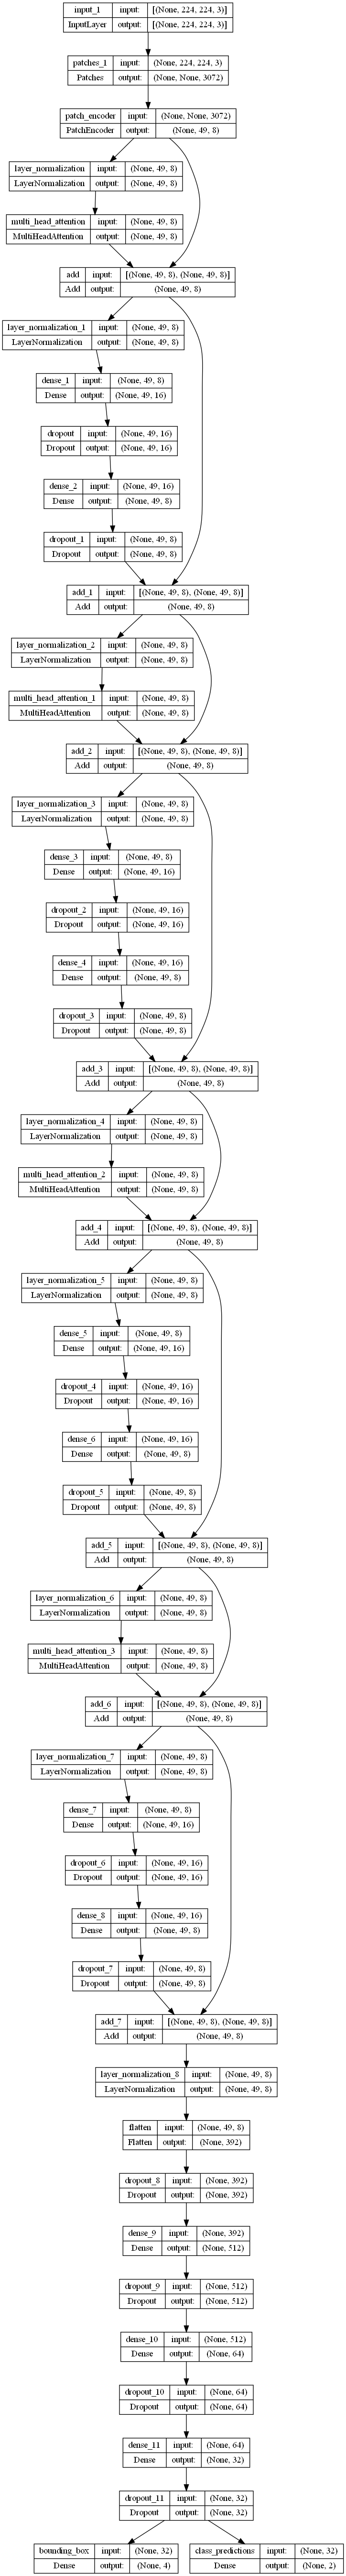

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # Compile the model with appropriate loss functions
    model.compile(
        optimizer='adam',
        loss={'bounding_box': 'mse', 'class_predictions': 'binary_crossentropy'},
        metrics = {'class_predictions' : 'accuracy', 'bounding_box' : calculate_iou }
    )
    
    # Train the model using both bounding_boxes_y and class_labels_y as y-values.
    history = model.fit(
        x = x_train,    # Your training image data
        y = {'bounding_box': bounding_boxes_y_train, 'class_predictions': class_labels_y_train},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=30),
        ],
    )
    
    dot_img_file = os.path.join(new_folder, 'architecture.png')
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(dot_img_file))
    return history, model



input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
projection_dim = 8
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history, model = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

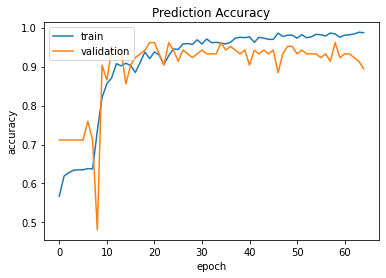

In [17]:
plt.plot(history.history['class_predictions_accuracy'])
plt.plot(history.history['val_class_predictions_accuracy'])
plt.title('Prediction Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'class predictions accuracy.png')
plt.savefig(model_file)
plt.show()

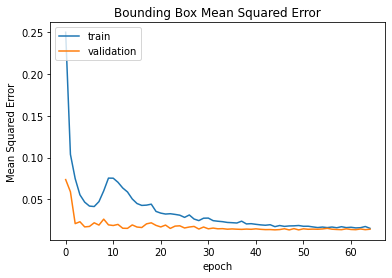

In [18]:
plt.plot(history.history['bounding_box_loss'])
plt.plot(history.history['val_bounding_box_loss'])
plt.title('Bounding Box Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'bounding box mean squared error.png')
plt.savefig(model_file)
plt.show()

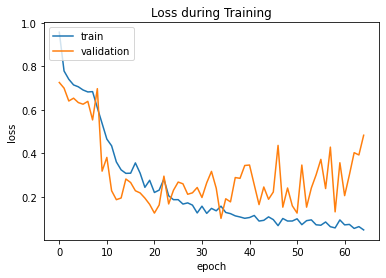

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss during Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'loss.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()

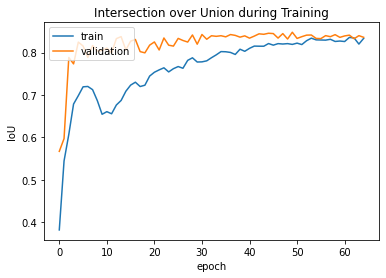

In [20]:
plt.plot(history.history['bounding_box_calculate_iou'])
plt.plot(history.history['val_bounding_box_calculate_iou'])
plt.title('Intersection over Union during Training')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'IoU.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()


predicted_box_coords:  [0.4626381  0.5171343  0.53899854 0.54948974]
actual_box_coords [0.5515625 0.6016166 0.703125  0.6073903]
predicted_labels:  [1.000000e+00 2.586904e-16]
predicted_label:  0
actual_label:  0


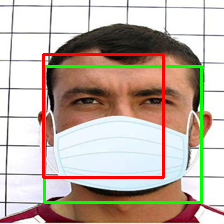

predicted_box_coords:  [0.47700384 0.50057334 0.47526425 0.52974033]
actual_box_coords [0.694 0.537 0.572 0.582]
predicted_labels:  [1.0000000e+00 2.2785276e-09]
predicted_label:  0
actual_label:  0


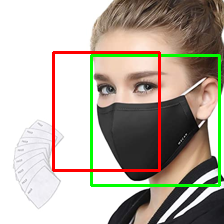

predicted_box_coords:  [0.463529  0.5071635 0.5022526 0.5377651]
actual_box_coords [0.5604839  0.57857144 0.37580645 0.80285716]
predicted_labels:  [1.0000000e+00 2.3443194e-12]
predicted_label:  0
actual_label:  0


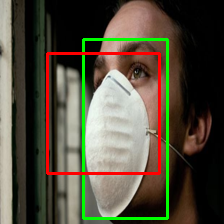

predicted_box_coords:  [0.45973226 0.5099727  0.5212178  0.5400083 ]
actual_box_coords [0.4781818  0.49726775 0.61454546 0.91803277]
predicted_labels:  [1.0000000e+00 5.3248383e-15]
predicted_label:  0
actual_label:  0


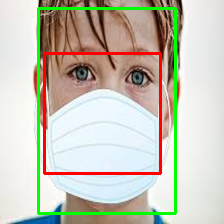

predicted_box_coords:  [0.50831324 0.5039476  0.5760229  0.58980274]
actual_box_coords [0.4077381 0.5058548 0.5654762 0.5948478]
predicted_labels:  [2.8252499e-08 1.0000000e+00]
predicted_label:  1
actual_label:  1


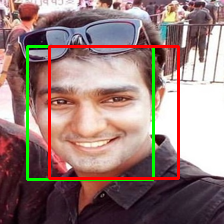

predicted_box_coords:  [0.49331388 0.4945857  0.44717115 0.5228285 ]
actual_box_coords [0.5883777  0.46615386 0.4164649  0.45846155]
predicted_labels:  [9.999995e-01 4.266456e-07]
predicted_label:  0
actual_label:  0


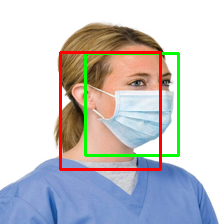

predicted_box_coords:  [0.5119989 0.5173776 0.5334302 0.571945 ]
actual_box_coords [0.5614806  0.5353846  0.32245922 0.59384614]
predicted_labels:  [2.0714961e-05 9.9997926e-01]
predicted_label:  1
actual_label:  1


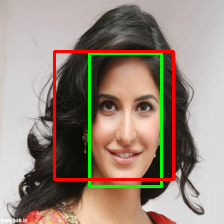

predicted_box_coords:  [0.49294016 0.49422365 0.43675727 0.52713746]
actual_box_coords [0.4542278 0.4464536 0.5842068 0.582282 ]
predicted_labels:  [9.999962e-01 3.862400e-06]
predicted_label:  0
actual_label:  0


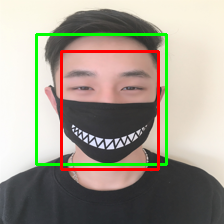

predicted_box_coords:  [0.48880804 0.49951756 0.47400117 0.52663326]
actual_box_coords [0.50775194 0.5299003  0.52602434 0.6566999 ]
predicted_labels:  [1.0000000e+00 3.1253705e-08]
predicted_label:  0
actual_label:  0


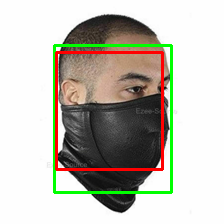

predicted_box_coords:  [0.46610424 0.47253644 0.41582644 0.48032123]
actual_box_coords [0.67558527 0.49702382 0.2742475  0.50595236]
predicted_labels:  [1.0000000e+00 8.0157486e-10]
predicted_label:  0
actual_label:  0


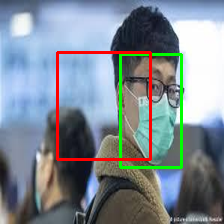

In [21]:
from IPython.display import display
from PIL import Image
for i in range(0, 10):
    image = x_test[i].numpy().astype("uint8")
    # Add an additional dimension for batch size
    image = np.expand_dims(image, axis=0)
    x_center_actual = bounding_boxes_y_test[i][0] * image_size
    y_center_actual = bounding_boxes_y_test[i][1] * image_size
    width_actual = bounding_boxes_y_test[i][2] * image_size
    height_actual = bounding_boxes_y_test[i][3] * image_size

    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min_actual = int(x_center_actual - (width_actual / 2))
    y_min_actual = int( y_center_actual - (height_actual / 2))
    x_max_actual = x_min_actual + int(width_actual)
    y_max_actual = y_min_actual + int(height_actual)

    top_left_actual = (x_min_actual, y_min_actual)
    bottom_right_actual = (x_max_actual, y_max_actual)




    predictions = model(image)


    # Extract the bounding box center coordinates from predictions
    predicted_box_coords = predictions[0].numpy()[0]
    print('predicted_box_coords: ', predicted_box_coords)
    print('actual_box_coords', bounding_boxes_y_test[i].numpy())
    x_center, y_center = predicted_box_coords[0] * image_size,  predicted_box_coords[1] * image_size
    width, height = predicted_box_coords[2] * image_size,  predicted_box_coords[3] * image_size

    #Extract the prediction label
    predicted_labels = predictions[1].numpy()[0]
    print('predicted_labels: ', predicted_labels)
    predicted_label =  np.argmax(predicted_labels)
    print('predicted_label: ', predicted_label)
    print('actual_label: ', np.argmax(class_labels_y_test[i].numpy()))
    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min = int(x_center - (width / 2))
    y_min = int( y_center - (height / 2))
    x_max = x_min + int(width)
    y_max = y_min + int(height)

    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    # Convert image to RGB if it's grayscale
    image = np.squeeze(image)  # Remove the extra batch dimension
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Now use the tuple coordinates in the cv2.rectangle function
    color = (0, 255, 0)  # Set green for actual
    # Draw rectangles
    image = cv2.rectangle(image, top_left_actual, bottom_right_actual, color, 2)
    color = (255, 0, 0)  # Set red for prediction
    # Draw rectangles
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    # Convert the numpy array to a PIL Image
    image_pil = Image.fromarray(image)

    # Display the image and make it persist
    display(image_pil)